In [142]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime
from datetime import date
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import cdist

# Data Preprocessing

In [143]:
dataframe = pd.read_csv("marketing_campaign.csv",sep = '\t')

## Dropping data with invalid or missing feature values

In [144]:
print(len(dataframe))

2240


In [145]:
dataframe = dataframe.dropna()

In [146]:
print(len(dataframe))

2216


Since the rows with invalid or missing values are only 24, the data loss is insignificant...

## Transforming the 'Marital_Status' labels into one-hot encoding

Since there is no natural ordering of the 'Marital_Status' labels, we decided to use one hot encoding instead of simple enumeration

In [147]:
dataframe['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [148]:
#Replacing 'YOLO', 'Alone', 'Absurd' with 'Single'
dataframe = dataframe.replace(['YOLO','Alone','Absurd'],'Single').reset_index().drop('index',axis = 1);
dataframe['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow'], dtype=object)

In [149]:
enc = LabelBinarizer()
enc.fit(dataframe.Marital_Status)
transformed = enc.transform(dataframe['Marital_Status'])
new_df= pd.DataFrame(transformed)
dataframe = dataframe.join(new_df)

### Dataframe Preview

In [150]:
dataframe

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,0,1,2,3,4
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,3,11,1,0,0,1,0,0
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,3,11,0,0,0,1,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,3,11,0,0,0,0,1,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,3,11,0,0,0,0,1,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,3,11,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,0,0,3,11,0,0,1,0,0,0
2212,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,0,0,3,11,0,0,0,0,1,0
2213,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,0,0,3,11,0,1,0,0,0,0
2214,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,0,0,3,11,0,0,0,0,1,0


### Replacing one hot IDs with the corresponding labels

In [151]:
#Finding manually the correspondance between one hot encodings and labels
mydict = {} 
for i in dataframe.values:
    mydict[i[3]] = i[-5:].tolist()
print(mydict)

{'Single': [0, 0, 1, 0, 0], 'Together': [0, 0, 0, 1, 0], 'Married': [0, 1, 0, 0, 0], 'Divorced': [1, 0, 0, 0, 0], 'Widow': [0, 0, 0, 0, 1]}


In [152]:
dataframe = dataframe.rename(columns = {0: 'Divorced',1:'Married',2:'Single',3:'Together',4:'Widow'})

## Transforming the 'Education' labels into enumerated values

Since there exists an ordinal relationship in the label values of 'Education', enumerated values are preferred over one hot encoding, in this case.

In [153]:
dataframe['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [154]:

correspondance = {
    'Basic' : 0,
    '2n Cycle':1,
    'Graduation':2,
    'Master':3,
    'PhD':4
}  

tempdt = dataframe.copy()
dataframe['Education'] = dataframe['Education'].apply(lambda row: correspondance[row]);

### Dataframe Preview

In [155]:
dataframe

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Divorced,Married,Single,Together,Widow
0,5524,1957,2,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,3,11,1,0,0,1,0,0
1,2174,1954,2,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,3,11,0,0,0,1,0,0
2,4141,1965,2,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,3,11,0,0,0,0,1,0
3,6182,1984,2,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,3,11,0,0,0,0,1,0
4,5324,1981,4,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,3,11,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,10870,1967,2,Married,61223.0,0,1,13-06-2013,46,709,...,0,0,3,11,0,0,1,0,0,0
2212,4001,1946,4,Together,64014.0,2,1,10-06-2014,56,406,...,0,0,3,11,0,0,0,0,1,0
2213,7270,1981,2,Divorced,56981.0,0,0,25-01-2014,91,908,...,0,0,3,11,0,1,0,0,0,0
2214,8235,1956,3,Together,69245.0,0,1,24-01-2014,8,428,...,0,0,3,11,0,0,0,0,1,0


## Transforming the dates column into DateTime format

In [156]:
dataframe['Dt_Customer'] = dataframe['Dt_Customer'].apply(lambda row : datetime.strptime(row,'%d-%m-%Y'))

### Dataframe Preview

In [157]:
dataframe

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Divorced,Married,Single,Together,Widow
0,5524,1957,2,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,3,11,1,0,0,1,0,0
1,2174,1954,2,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,3,11,0,0,0,1,0,0
2,4141,1965,2,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,3,11,0,0,0,0,1,0
3,6182,1984,2,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,3,11,0,0,0,0,1,0
4,5324,1981,4,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,3,11,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,10870,1967,2,Married,61223.0,0,1,2013-06-13,46,709,...,0,0,3,11,0,0,1,0,0,0
2212,4001,1946,4,Together,64014.0,2,1,2014-06-10,56,406,...,0,0,3,11,0,0,0,0,1,0
2213,7270,1981,2,Divorced,56981.0,0,0,2014-01-25,91,908,...,0,0,3,11,0,1,0,0,0,0
2214,8235,1956,3,Together,69245.0,0,1,2014-01-24,8,428,...,0,0,3,11,0,0,0,0,1,0


#Plots

## Number of instances for each of the 'Education' categories

Text(0, 0.5, 'Count')

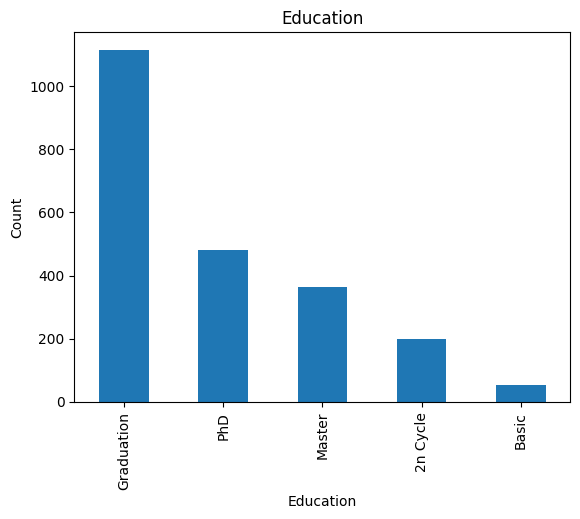

In [158]:
tempdt['Education'].value_counts().plot(kind = 'bar')
plt.title('Education')
plt.xlabel('Education')
plt.ylabel('Count')


## Number of instances for each of the 'Marital_Status' categories



Text(0, 0.5, 'Count')

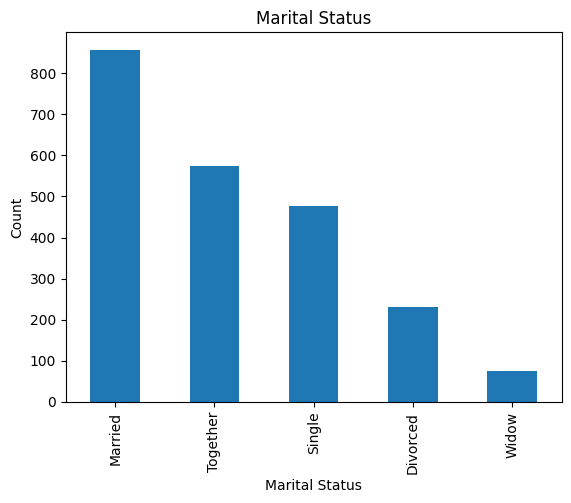

In [159]:
dataframe['Marital_Status'].value_counts().plot(kind = 'bar')
plt.title('Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')


# Creation of new features

In [160]:
dataframe['Recency'] = dataframe['Recency'].apply(lambda row : (date.today() - date.fromordinal(date.today().toordinal() - row)).days)
dataframe['Recency']


0       58
1       38
2       26
3       26
4       94
        ..
2211    46
2212    56
2213    91
2214     8
2215    40
Name: Recency, Length: 2216, dtype: int64

In [161]:
curryear = date.today().year
ages = dataframe['Year_Birth'].apply(lambda year : curryear - year)
ages = pd.DataFrame(ages).rename(columns = {"Year_Birth" : "Age"})
ages

,Age
0,66
1,69
2,58
3,39
4,42
...,...
2211,56
2212,77
2213,42
2214,67


In [162]:
dataframe['Spent'] = dataframe.apply(lambda row : row['MntWines'] + row['MntFruits'] + row['MntMeatProducts'] + row['MntFishProducts'] + row['MntSweetProducts'] +row['MntGoldProds'],axis = 1)
print(dataframe['Spent'])


0       1617
1         27
2        776
3         53
4        422
        ... 
2211    1341
2212     444
2213    1241
2214     843
2215     172
Name: Spent, Length: 2216, dtype: int64


In [163]:
dataframe['children'] = dataframe.apply(lambda row : row['Kidhome'] + row['Teenhome'],axis = 1)
print(dataframe['children'])

0       0
1       2
2       0
3       1
4       1
       ..
2211    1
2212    3
2213    0
2214    1
2215    2
Name: children, Length: 2216, dtype: int64


In [164]:
dataframe['Family_Size'] = dataframe.apply(lambda row : row['children'] + 1 + (row['Marital_Status'] == 'Married' or row['Marital_Status'] == 'Together'),axis = 1)
print(dataframe['Family_Size'])

0       1
1       3
2       2
3       3
4       3
       ..
2211    3
2212    5
2213    1
2214    3
2215    4
Name: Family_Size, Length: 2216, dtype: int64


In [165]:
dataframe['Is_Parent'] = dataframe.apply(lambda row : int(row['children']>0) ,axis = 1)
print(dataframe['Is_Parent'])

0       0
1       1
2       0
3       1
4       1
       ..
2211    1
2212    1
2213    0
2214    1
2215    1
Name: Is_Parent, Length: 2216, dtype: int64


In [166]:
dataframe['Living_With'] = dataframe.apply(lambda row : "Partner" if row['Marital_Status'] == 'Together' or row['Marital_Status'] == 'Married' else "Alone",axis = 1)
print(dataframe['Living_With'])

0         Alone
1         Alone
2       Partner
3       Partner
4       Partner
         ...   
2211    Partner
2212    Partner
2213      Alone
2214    Partner
2215    Partner
Name: Living_With, Length: 2216, dtype: object


In [167]:
ages.min()

Age    27
dtype: int64

In [168]:
def make_age_group(age):
	if age < 31:
		return "21-30"
	elif age < 41:
		return "31-40"
	elif age < 51:
		return "41-50"
	elif age < 61:
		return "51-60"
	elif age < 71:
		return "61-70"
	else:
		return ">80"

dataframe['Age_Group'] = ages['Age'].apply(make_age_group)
print(dataframe['Age_Group'])

0       61-70
1       61-70
2       51-60
3       31-40
4       41-50
        ...  
2211    51-60
2212      >80
2213    41-50
2214    61-70
2215    61-70
Name: Age_Group, Length: 2216, dtype: object


## Outlier removal

Removing instances that lie in extreme percentiles of the dataset

In [169]:
from scipy import stats
#  save csv so far
dataframe.to_csv('marketing_campaign_cleaned.csv',index = False)
cols = ['Income','Spent','Family_Size','Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

dataframe = dataframe[(np.abs(stats.zscore(dataframe[cols])) < 3).all(axis=1)]






In [170]:
print(len(dataframe))

# From 2216 to 1954

1954


## Heatmap

<AxesSubplot: >

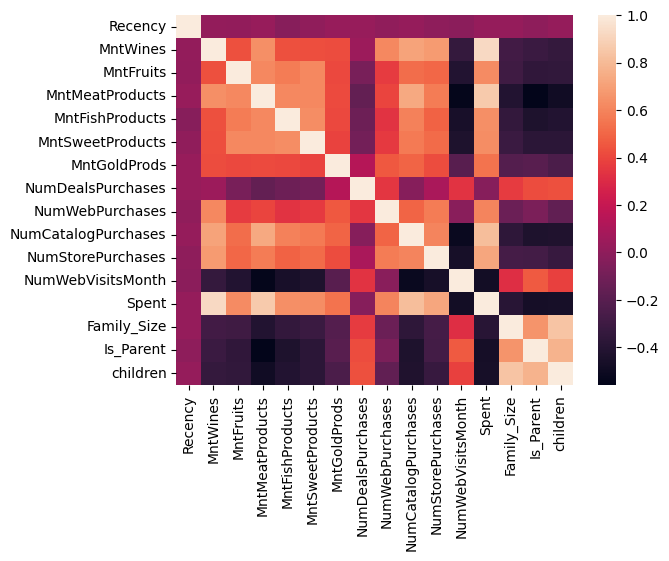

In [171]:
dt = dataframe[['Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth','Spent','Family_Size','Is_Parent', 'children']]

import seaborn as sns
corr = dt.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

The heatmap demonstrates which features are correlated with each other. For example, the value of the 'Spent' feature is highly correlated with the Number of Catalog Purchases, the Amount of Meat Products and the Amount of Wines. 

## Graphs

### (1)	What is the Marital Status of the customers?

Text(0, 0.5, 'Count')

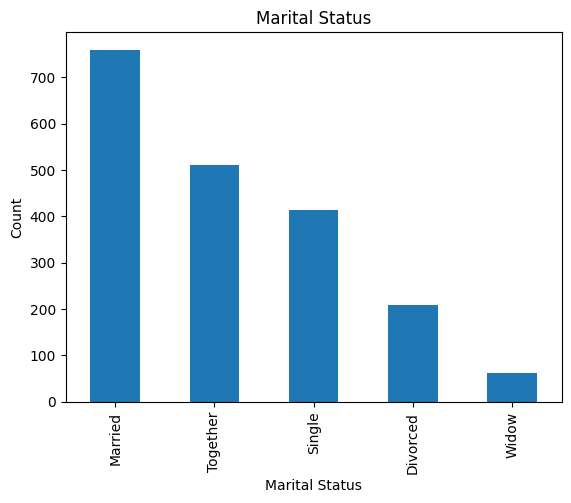

In [172]:
dataframe['Marital_Status'].value_counts().plot(kind = 'bar')
plt.title('Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')

### (2) Amount of customer complaints

Text(0, 0.5, 'Number of Customers')

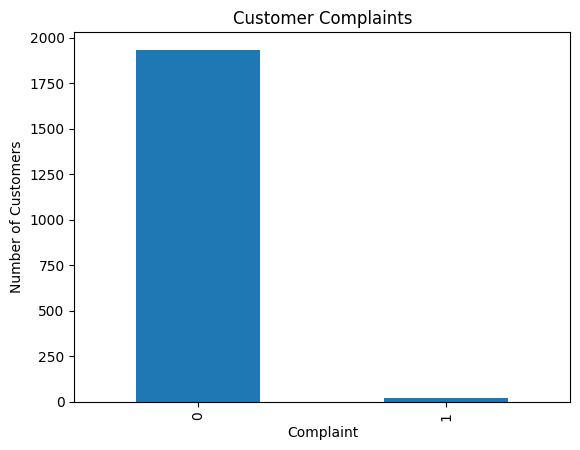

In [173]:
dataframe['Complain'].value_counts().plot(kind = 'bar')
plt.title('Customer Complaints')
plt.xlabel('Complaint')
plt.ylabel('Number of Customers')

### (3) Correlation between Spending and Marital Status

Text(0, 0.5, 'Amount Spent')

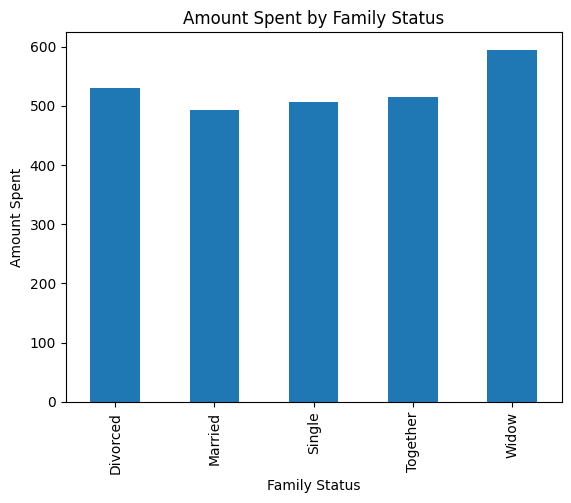

In [174]:
dataframe.groupby('Marital_Status')['Spent'].mean().plot(kind = 'bar')
plt.title('Amount Spent by Family Status')
plt.xlabel('Family Status')
plt.ylabel('Amount Spent')


### (4) Correlation between Spending and Amount of Children and Family Size

Text(0, 0.5, 'Amount Spent')

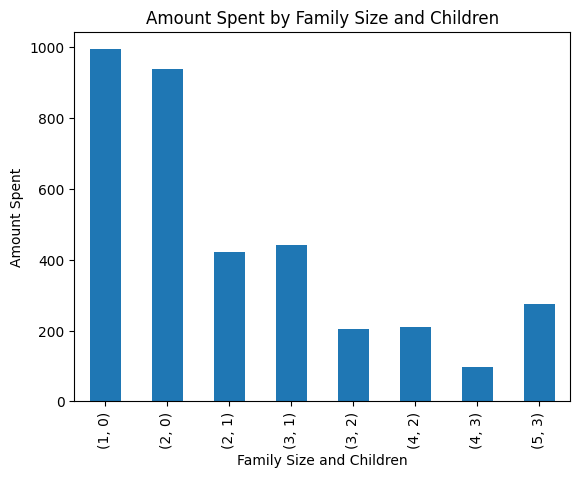

In [175]:
dataframe.groupby(['Family_Size','children'])['Spent'].mean().plot(kind = 'bar')
plt.title('Amount Spent by Family Size and Children')
plt.xlabel('Family Size and Children')
plt.ylabel('Amount Spent')

### (5) Correlation between Spending and Age Group

Text(0, 0.5, 'Amount Spent')

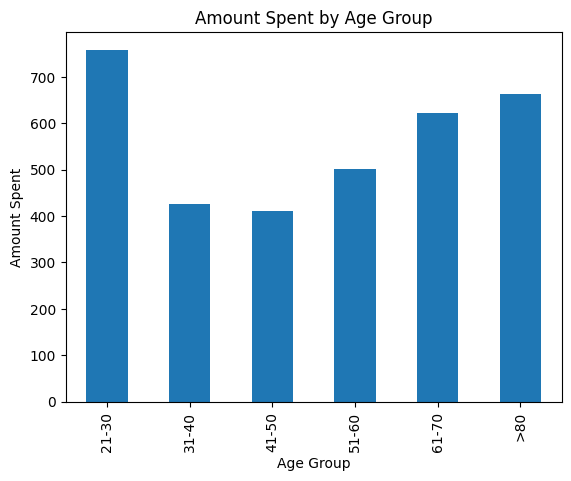

In [176]:
dataframe.groupby('Age_Group')['Spent'].mean().plot(kind = 'bar')
plt.title('Amount Spent by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Amount Spent')

### (6) Correlation between Spending and Income

In [177]:
# creating income groups with 5000 step
dataframe['Income_Group'] = dataframe['Income'].apply(lambda x: int(x/5000)*5000)



/tmp/ipykernel_10379/2508414025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Income_Group'] = dataframe['Income'].apply(lambda x: int(x/5000)*5000)


Text(0, 0.5, 'Amount Spent')

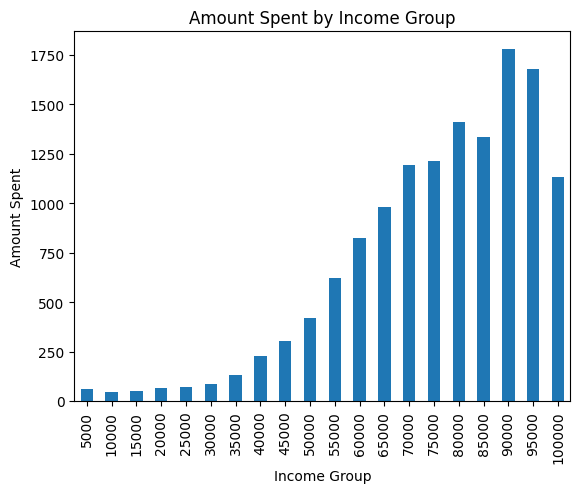

In [178]:
dataframe.groupby('Income_Group')['Spent'].mean().plot(kind = 'bar')
plt.title('Amount Spent by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Amount Spent')


### (7) Correlation between Education and Income

Text(0, 0.5, 'Income')

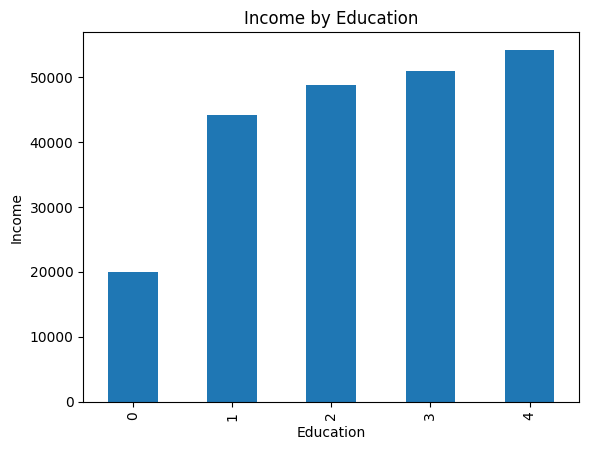

In [179]:
dataframe.groupby('Education')['Income'].mean().plot(kind = 'bar')
plt.title('Income by Education')
plt.xlabel('Education')
plt.ylabel('Income')


### (8) Correlation between Income and Family size

Text(0, 0.5, 'Income')

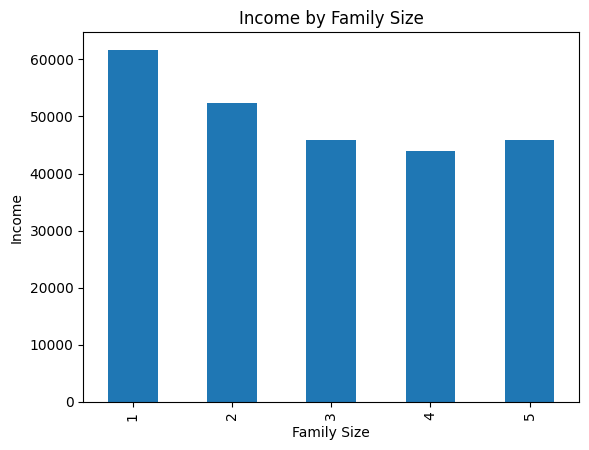

In [180]:
dataframe.groupby('Family_Size')['Income'].mean().plot(kind = 'bar')
plt.title('Income by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Income')


### (9) Correlation between Income and Amount of Children

Text(0, 0.5, 'Income')

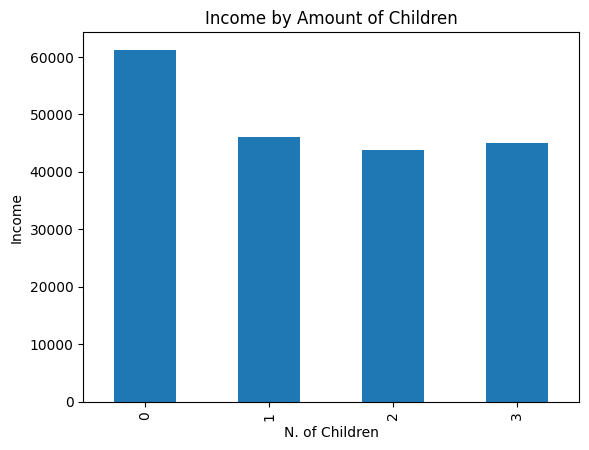

In [181]:
dataframe.groupby('children')['Income'].mean().plot(kind = 'bar')
plt.title('Income by Amount of Children')
plt.xlabel('N. of Children')
plt.ylabel('Income')

### (10) Correlation between Income and Living With

Text(0, 0.5, 'Income')

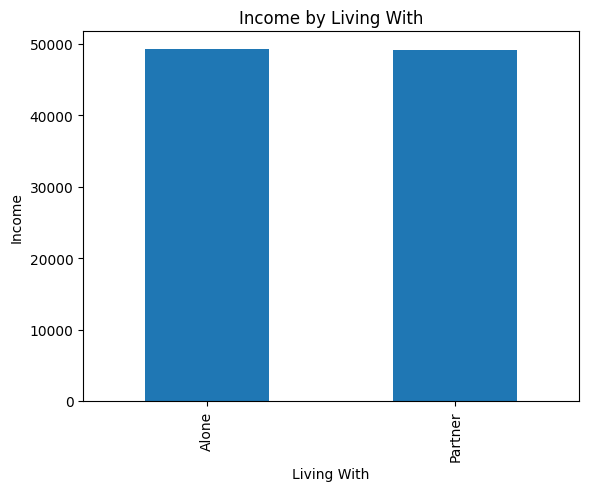

In [182]:
dataframe.groupby('Living_With')['Income'].mean().plot(kind = 'bar')
plt.title('Income by Living With')
plt.xlabel('Living With')
plt.ylabel('Income')

# PCA

In [183]:
# Age group quantization
dataframe['Age_Group'] = dataframe['Age_Group'].map({'21-30': 1, '31-40': 2, '41-50': 3, '51-60': 4, '61-70': 5, '>80': 6})
# keeping only a subset of the columns
dataframe = dataframe[['Education', 'Income_Group', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Divorced', 'Married', 'Single', 'Together', 'Widow', 'Spent', 'Family_Size', 'Is_Parent', 'children', 'Age_Group']]


# Standardization
scaler = StandardScaler()
dataframe = scaler.fit_transform(dataframe)

# PCA
pca = PCA(n_components = 3, whiten=True)
dataframe = pca.fit_transform(dataframe)


/tmp/ipykernel_10379/1473289382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Age_Group'] = dataframe['Age_Group'].map({'21-30': 1, '31-40': 2, '41-50': 3, '51-60': 4, '61-70': 5, '>80': 6})


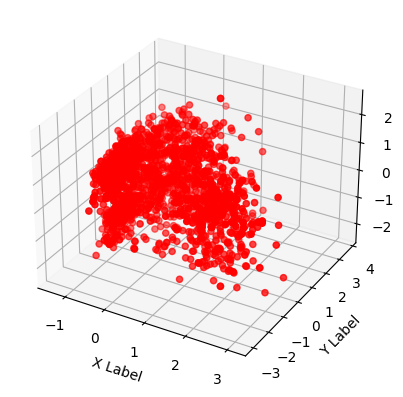

In [184]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataframe[:,0], dataframe[:,1], dataframe[:,2], c='r', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()


# Clustering

## Agglomerative

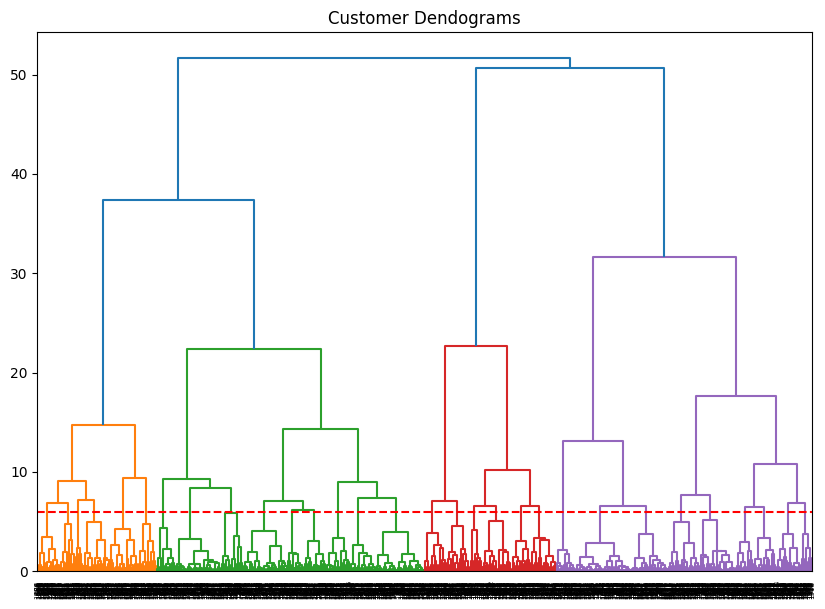

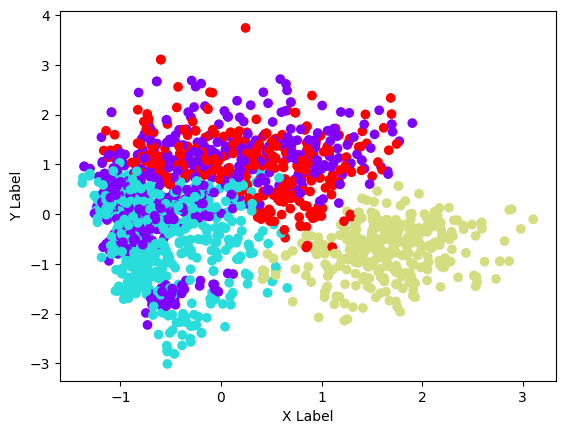

In [191]:

agglomerative = AgglomerativeClustering(n_clusters=4, metric = 'euclidean', linkage = 'ward', compute_distances=True)
	
agglomerative.fit(dataframe)

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(dataframe, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')
plt.show()

plt.scatter(dataframe[:,0], dataframe[:,1], c=agglomerative.labels_, cmap='rainbow')
plt.xlabel('X Label')
plt.ylabel('Y Label')

plt.show()


## K-Means

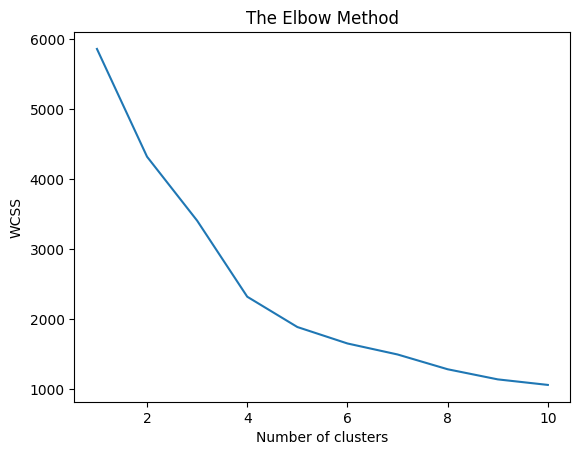

In [186]:
# elbow method for k-means clustering
wcss = []
for i in range(1, 11):
	kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto' , random_state=42)
	kmeans.fit(dataframe)
	wcss.append(kmeans.inertia_)

plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.plot(range(1, 11), wcss)




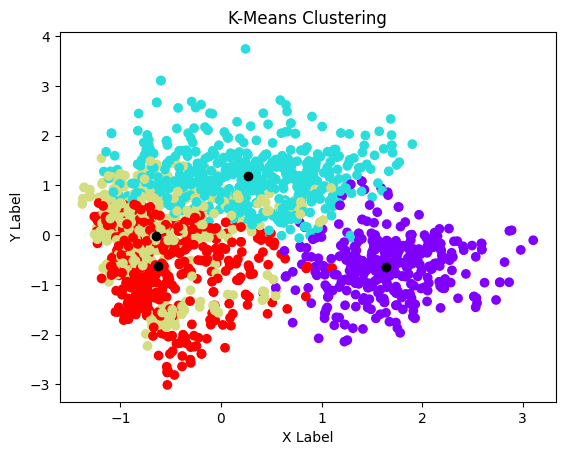

In [190]:
# create plot for k=5 clusters 
kmeans = KMeans(n_clusters=4, init='k-means++', n_init='auto' , random_state=42)
kmeans.fit(dataframe)
plt.scatter(dataframe[:,0], dataframe[:,1], c=kmeans.labels_, cmap='rainbow')
plt.title('K-Means Clustering')
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')
plt.show()

# Cluster Profiling

In [188]:
cluster_centers = kmeans.cluster_centers_
print(cluster_centers)

#Inverse Transform PCA
cluster_centers = pca.inverse_transform(cluster_centers)

#Undo standardization
cluster_centers = scaler.inverse_transform(cluster_centers)

reconstructed_df = pd.DataFrame(cluster_centers)
reconstructed_df.columns = ['Education', 'Income_Group', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Divorced', 'Married', 'Single', 'Together', 'Widow', 'Spent', 'Family_Size', 'Is_Parent', 'children', 'Age_Group']

print(pca.components_)



[[ 1.64563369 -0.64732567 -0.24522142]
 [ 0.27025264  1.19117442  0.43240463]
 [-0.65066822 -0.01933787 -1.09177755]
 [-0.62994872 -0.61289471  0.72009244]]
[[ 0.04097674  0.29702699  0.00346995  0.28060335  0.24992078  0.30696282
   0.26019596  0.25652827  0.19952022 -0.05143031  0.20060108  0.29997765
   0.27052226 -0.2218152   0.01043028 -0.0187495   0.01218365 -0.00516186
   0.01832124  0.33380751 -0.19221107 -0.21543623 -0.21714719  0.05635576]
 [ 0.13904813  0.14836308  0.0273016   0.18420031  0.01276263 -0.02139773
  -0.03402333 -0.00831847  0.13610257  0.4266477   0.31847322  0.07577033
   0.16589842  0.12924893 -0.00954384  0.12037978 -0.24144727  0.097008
   0.00173332  0.11069067  0.42221966  0.34908459  0.37237235  0.19196218]
 [ 0.11168994 -0.01398641  0.01474444  0.08244521 -0.09733071 -0.05442554
  -0.0915933  -0.11574037  0.06802995  0.19791427  0.15359844  0.0040545
   0.02737735  0.14191895  0.29864421 -0.68265207  0.38696704  0.12062789
   0.16816572  0.01711892 -0.2

In [189]:
reconstructed_df

,Education,Income_Group,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,Divorced,Married,Single,Together,Widow,Spent,Family_Size,Is_Parent,children,Age_Group
0,2.486731,70836.171656,48.659410,618.499227,54.483571,394.390961,81.944278,58.215905,69.576784,1.115980,...,0.095740,0.388601,0.288468,0.190057,0.037134,1277.110726,1.559385,0.172546,-0.019273,3.867591
1,2.841945,56581.106610,50.978204,467.408896,24.473267,160.614617,32.057851,23.904948,56.230004,3.699074,...,0.153880,0.311062,0.113467,0.370631,0.050960,764.689583,3.112927,0.998482,1.431234,4.449967
2,2.236937,36275.976487,48.347692,68.748292,10.127003,43.769866,13.923281,10.849565,17.190565,1.988518,...,-0.027176,0.865090,-0.013626,0.190790,-0.015077,164.608573,3.293857,0.875422,1.237978,3.458371
3,2.366166,33200.392843,48.581970,78.444143,3.576045,28.146084,7.075167,3.384182,18.826012,2.060200,...,0.187934,0.042287,0.445055,0.272022,0.052701,139.451633,2.373944,0.813950,1.059635,3.678544
